## CSC345 - Big Data & Machine Learning - Coursework: Image Classification

## Tim Deville (2003506)

# Method A: Convolutional Neural Network

## Step 1: Dataset Preprocessing

### Import libraries:

In [1]:
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
import skimage.feature
from sklearn.svm import SVC
from sklearn.decomposition import PCA

### Load dataset from file, check file shape:

In [2]:
# Function for loading the coarse and fine data labels from the provided csv files
def read_text_labels():
    coarse_file = open("coarse_labels.csv", "r")
    fine_file = open("fine_labels.csv", "r")

    coarse = list(csv.reader(coarse_file, delimiter=","))
    fine = list(csv.reader(fine_file, delimiter=","))

    coarse_file.close()
    fine_file.close()
    return coarse[0], fine[0]

In [3]:
# Training and testing image datasets
X_train = np.load('trnImage.npy')
X_test = np.load('tstImage.npy')


# Labels data (numerical) for coarse and fine datasets
y_train_coarse = np.load('trnLabel_coarse.npy')
y_test_coarse = np.load('tstLabel_coarse.npy')
y_train_fine = np.load('trnLabel_fine.npy')
y_test_fine = np.load('tstLabel_fine.npy')

# Generate list of text labels from csv file
coarse_list, fine_list = read_text_labels()

FileNotFoundError: [Errno 2] No such file or directory: 'trnImage.npy'

In [4]:
# Function to check the shape of the image data
def check_x_data_shape():
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

In [5]:
# Function to check the shape of the label data
def check_y_data_shape():
    print('y_train_fine shape:', y_train_fine.shape)
    print('y_test_fine shape:', y_test_fine.shape)
    print('y_train_course shape:', y_train_coarse.shape)
    print('y_test_course shape:', y_test_coarse.shape)

### Swap order of input shape ready for CNN:

In [6]:
check_x_data_shape()

X_train shape: (32, 32, 3, 50000)
X_test shape: (32, 32, 3, 10000)


In [7]:
# reshape data for CNN - E.g. (50000, 32, 32, 3) rather than (32,32,3,50000)
X_train = np.transpose(X_train, axes=[3,0,1,2])
X_test = np.transpose(X_test, axes=[3,0,1,2])
check_x_data_shape()

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)


### Change labels to one-hot encoding:

In [8]:
# Keep a copy of the original test labels to display later
y_test_coarse_original = y_test_coarse.copy()
y_test_fine_original = y_test_fine.copy()

# Change to onehot encoding for neural network training
y_train_coarse = to_categorical(y_train_coarse)
y_test_coarse = to_categorical(y_test_coarse)
y_train_fine = to_categorical(y_train_fine)
y_test_fine = to_categorical(y_test_fine)

### Check images and labels have been correctly set up

In [9]:
# Function to select 16 random images from the test dataset.
# Displays the image with the corresponding text label
def display_random_images():
    plt.figure(figsize=(8, 8))
    for i in range (16):
        rand_num = np.random.randint(0, 10000)
        image = X_test[rand_num]
        label = fine_list[y_test_fine_original[rand_num]]
        plt.subplot(4,4, i+1)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(image)
        plt.title(label)

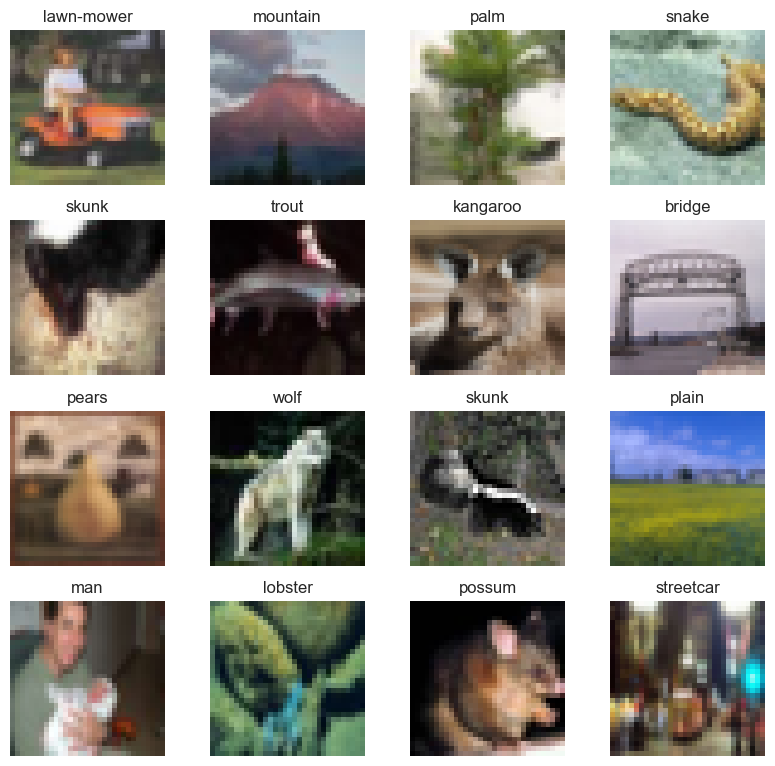

In [10]:
display_random_images()

## Step 2: Build CNN model

In [11]:
# Function to create and return a CNN model
def create_cnn(num_classes):
    model = Sequential()
    # First Convolution layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(3, 3)))
    # Second Convolution layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(3, 3)))
    # Flatten the data before passing to dense layer
    model.add(Flatten())
    # Dense layer
    model.add(Dense(512, activation='relu'))
    # Apply batch normalisation before final dense layer
    model.add(BatchNormalization())
    # Final dense layer to classify images based on number of classes in fine/coarse dataset
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    # Compile using Adam optimiser
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=tf.keras.metrics.CategoricalAccuracy())

    return model

### Fit training data to X_train using coarse labels

In [12]:
## Stops the training process early if the validation loss is not improving.
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [13]:
coarse_model = create_cnn(20)
coarse_history=coarse_model.fit(X_train, y_train_coarse, epochs=20, validation_split=0.2, verbose=1, shuffle=True, callbacks=[earlyStopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 512)               1

### Use the same CNN model to train for fine label dataset

In [15]:
fine_model = create_cnn(100)
fine_history=fine_model.fit(X_train, y_train_fine, epochs=20, validation_split=0.2, verbose=1, shuffle=True, callbacks=[earlyStopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)              

# Step 3a: Evaluate Training Performance & Accuracy: Coarse Label Dataset

### Evaluate trained model accuracy

In [16]:
coarse_results = coarse_model.evaluate(X_test, y_test_coarse)
print(f'Test set loss: {coarse_results[0]:0.2f}, test set accuracy: {coarse_results[1]*100:0.2f}%')

313/313 [==============================] - 1s 4ms/step - loss: 1.7241 - categorical_accuracy: 0.4778
Test set loss: 1.72, test set accuracy: 47.78%


### Plot training Metrics

In [17]:
# Function to plot the training data
def plot_training_data(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

    for ax in axes:
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')

    axes[0].set_title("Accuracy Curves")
    axes[0].plot(history.history['categorical_accuracy'])
    axes[0].plot(history.history['val_categorical_accuracy'])
    axes[0].legend(['Training Accuracy',
                    'Validation Accuracy'])

    axes[1].set_title("Loss Curves")
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].legend(['Training Loss',
                    'Validation Loss'])

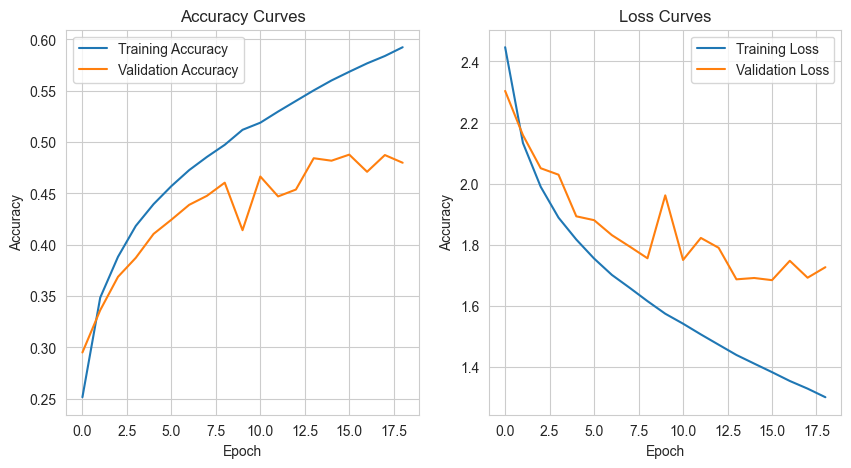

In [18]:
plot_training_data(coarse_history)

### Show classification Report

In [19]:
coarse_predictions = coarse_model.predict(X_test)
predicted_classes = coarse_predictions.argmax(axis=1)
print(classification_report(y_test_coarse_original,predicted_classes))


313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.48      0.35      0.41       500
           1       0.57      0.40      0.47       500
           2       0.59      0.78      0.67       500
           3       0.31      0.64      0.41       500
           4       0.63      0.59      0.61       500
           5       0.38      0.38      0.38       500
           6       0.48      0.59      0.53       500
           7       0.36      0.59      0.44       500
           8       0.41      0.44      0.43       500
           9       0.61      0.52      0.56       500
          10       0.70      0.69      0.69       500
          11       0.54      0.26      0.35       500
          12       0.48      0.29      0.37       500
          13       0.32      0.21      0.26       500
          14       0.53      0.58      0.55       500
          15       0.39      0.21      0.27       500
          16       0.34   

### Plot heatmap for coarse label confusion matrix (normalised across prediction columns)

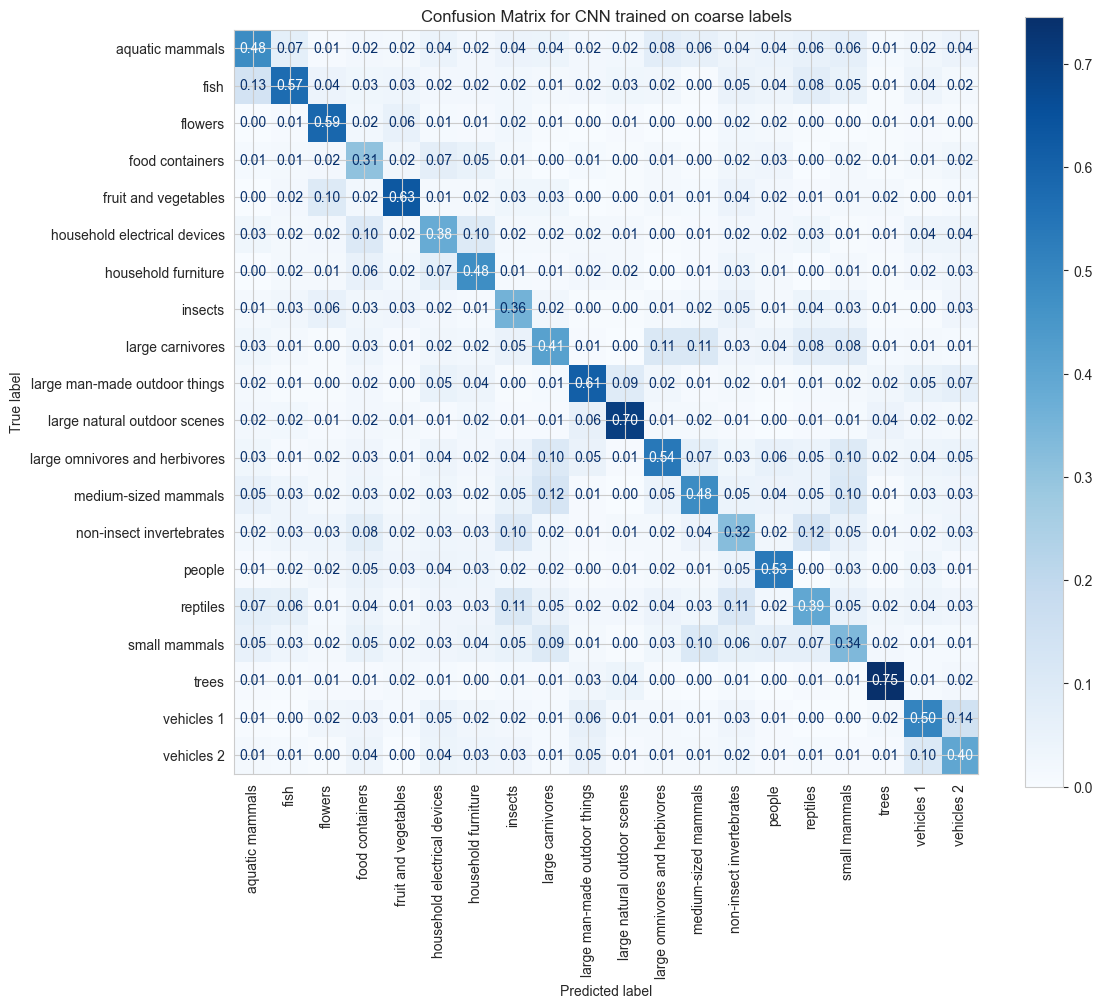

In [20]:
coarse_confusion_matrix = confusion_matrix(y_test_coarse_original,predicted_classes, normalize='pred')
coarse_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=coarse_confusion_matrix, display_labels=coarse_list)
fig, ax = plt.subplots(figsize=(12,10))
plt.title("Confusion Matrix for CNN trained on coarse labels")
coarse_matrix_plot.plot(ax=ax, xticks_rotation='vertical', values_format= '.2f', cmap="Blues")
plt.show()

# Step 3b: Evaluate Training Performance & Accuracy: Fine Label Dataset

### Evaluate result accuracy

In [21]:
fine_results = fine_model.evaluate(X_test, y_test_fine)
print(f'Test set loss: {fine_results[0]:0.2f}, test set accuracy: {fine_results[1]*100:0.2f}%')

313/313 [==============================] - 1s 3ms/step - loss: 2.5136 - categorical_accuracy: 0.3783
Test set loss: 2.51, test set accuracy: 37.83%


### Plot training Metrics

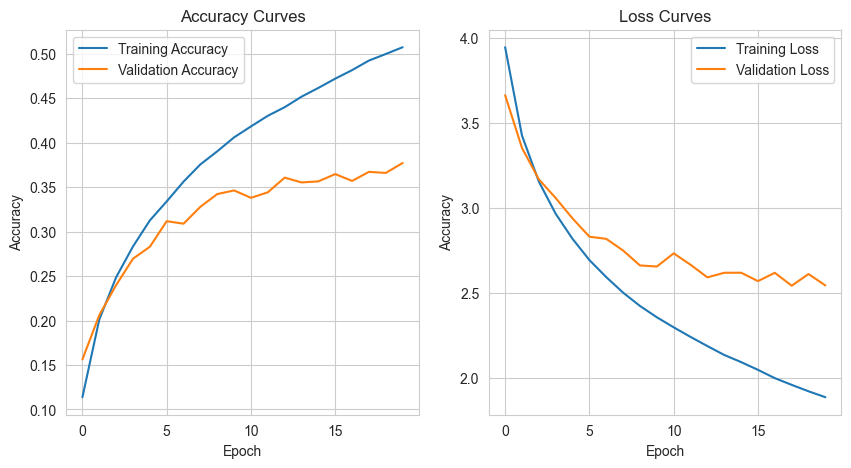

In [22]:
plot_training_data(fine_history)

### Show classification Report

In [23]:
fine_predictions = fine_model.predict(X_test)
fine_predicted_classes = fine_predictions.argmax(axis=1)
print(classification_report(y_test_fine_original,fine_predicted_classes))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.74      0.67      0.71       100
           1       0.43      0.55      0.48       100
           2       0.28      0.18      0.22       100
           3       0.22      0.17      0.19       100
           4       0.27      0.19      0.22       100
           5       0.22      0.39      0.28       100
           6       0.31      0.38      0.34       100
           7       0.51      0.32      0.39       100
           8       0.35      0.56      0.43       100
           9       0.58      0.48      0.52       100
          10       0.23      0.15      0.18       100
          11       0.38      0.10      0.16       100
          12       0.49      0.39      0.44       100
          13       0.29      0.30      0.30       100
          14       0.28      0.32      0.30       100
          15       0.27      0.21      0.24       100
          16       0.34   

### Plot heatmap for a random subset of 20 out of 100 fine labels (too large to display all 100 classes)

52


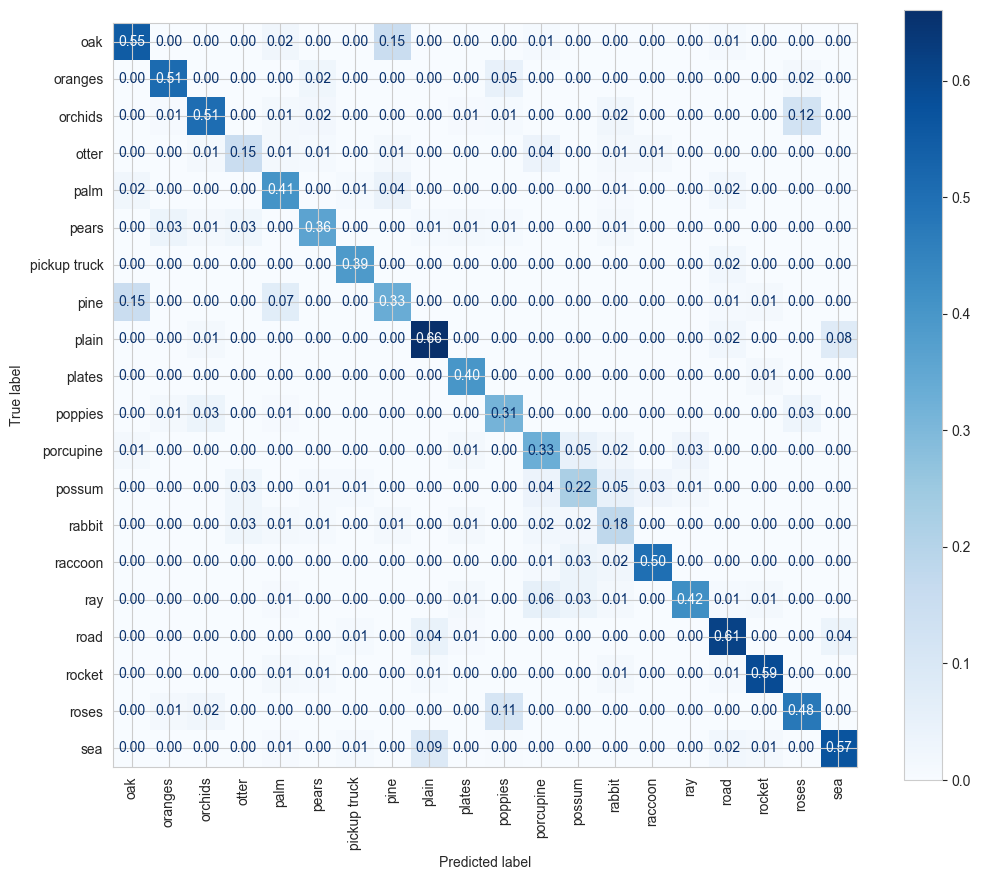

In [24]:
fine_confusion_matrix = confusion_matrix(y_test_fine_original,fine_predicted_classes, normalize='pred')
rand_i = np.random.randint(0, y_test_fine[0].size - 20)
print(rand_i)

first_20_matrix = fine_confusion_matrix[rand_i: rand_i+20, rand_i: rand_i+20]

fine_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=first_20_matrix, display_labels=fine_list[rand_i:rand_i+20])
fig, ax = plt.subplots(figsize=(12,10))
fine_matrix_plot.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap="Blues")
plt.show()

# Step 4: Test classifier on random images from test datasets

In [25]:
def predict_class_label_svm(img, cnn_model, is_fine=True):
    predictions = cnn_model.predict(img.reshape(1,32,32,3))
    class_prob = np.amax(predictions, axis=1)
    class_prob = np.round(class_prob[0], 4)
    print(class_prob)
    class_prediction = int(np.argmax(predictions,axis=1))

    if is_fine:
        return fine_list[class_prediction], class_prob*100
    else:
        return coarse_list[class_prediction], class_prob*100

In [26]:
def classify_image_test_svm(model, is_fine = True):
    plt.figure(figsize=(12, 10))
    for i in range (16):
        rand_num = np.random.randint(0, 10000)
        test_image = X_test[rand_num]
        predicted_label, probability = predict_class_label_svm(X_test[rand_num], model, is_fine)
        if is_fine:
            actual_label = fine_list[(y_test_fine_original[rand_num])]
        else:
            actual_label = coarse_list[(y_test_coarse_original[rand_num])]
        plt.subplot(4,4, i+1)
        plt.tight_layout()
        plt.xticks([])
        plt.yticks([])
        plt.imshow(test_image)
        plt.title("Actual: {}".format(actual_label))
        plt.xlabel("Predicted: {0}, {1:.2f}%".format(predicted_label, probability))

### Coarse Labelled Images

1/1 [==============================] - 0s 13ms/step
0.7654
1/1 [==============================] - 0s 15ms/step
0.4415
1/1 [==============================] - 0s 12ms/step
0.6598
1/1 [==============================] - 0s 13ms/step
0.5097
1/1 [==============================] - 0s 13ms/step
0.596
1/1 [==============================] - 0s 12ms/step
0.9625
1/1 [==============================] - 0s 11ms/step
0.2789
1/1 [==============================] - 0s 11ms/step
0.2878
1/1 [==============================] - 0s 11ms/step
0.8891
1/1 [==============================] - 0s 12ms/step
0.9911
1/1 [==============================] - 0s 12ms/step
0.2939
1/1 [==============================] - 0s 13ms/step
0.9046
1/1 [==============================] - 0s 13ms/step
0.8685
1/1 [==============================] - 0s 11ms/step
0.3516
1/1 [==============================] - 0s 12ms/step
0.9122
1/1 [==============================] - 0s 12ms/step
0.3494


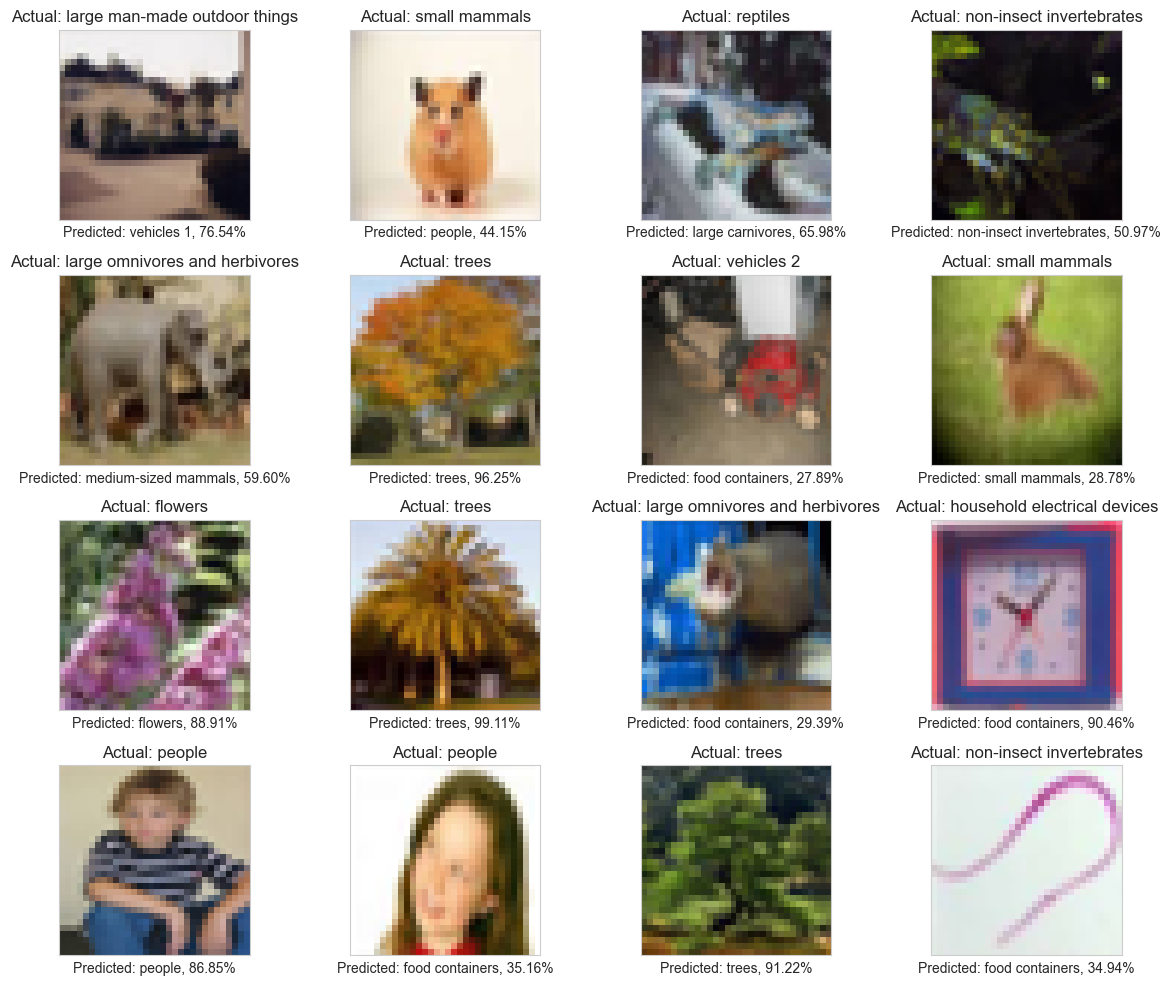

In [27]:
classify_image_test_svm(coarse_model, is_fine=False)

### Fine Labelled Images

1/1 [==============================] - 0s 12ms/step
0.325
1/1 [==============================] - 0s 12ms/step
0.8054
1/1 [==============================] - 0s 12ms/step
0.3077
1/1 [==============================] - 0s 12ms/step
0.7716
1/1 [==============================] - 0s 11ms/step
0.898
1/1 [==============================] - 0s 14ms/step
0.9343
1/1 [==============================] - 0s 12ms/step
0.335
1/1 [==============================] - 0s 12ms/step
0.6669
1/1 [==============================] - 0s 12ms/step
0.1766
1/1 [==============================] - 0s 11ms/step
0.2946
1/1 [==============================] - 0s 11ms/step
0.7687
1/1 [==============================] - 0s 12ms/step
0.7595
1/1 [==============================] - 0s 13ms/step
0.9187
1/1 [==============================] - 0s 11ms/step
0.8456
1/1 [==============================] - 0s 11ms/step
0.6496
1/1 [==============================] - 0s 11ms/step
0.3118


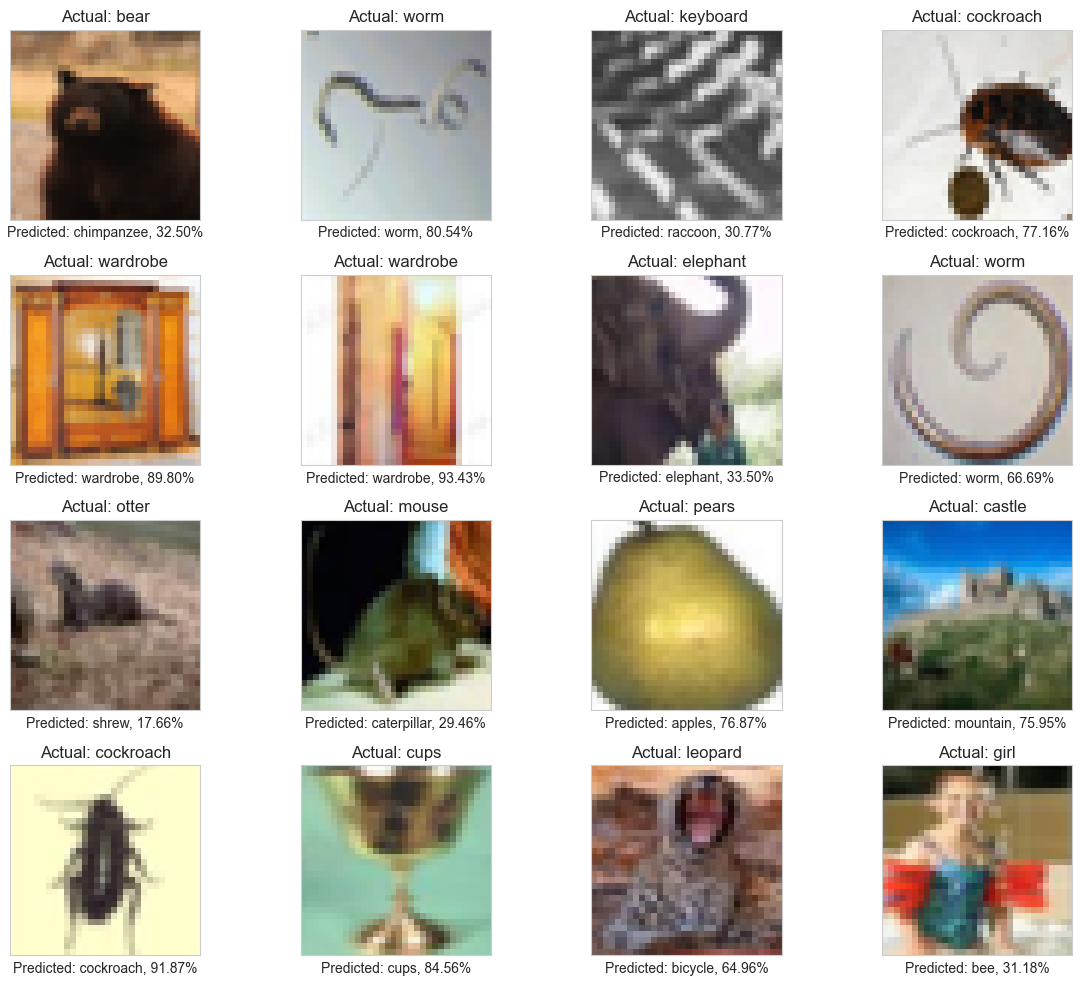

In [28]:
classify_image_test_svm(fine_model, is_fine=True)

# Method B: PCA & SVM

## Step 1: Reset data from previous experiment

In [29]:
X_train = np.load('trnImage.npy')
X_test = np.load('tstImage.npy')

y_train_coarse = np.load('trnLabel_coarse.npy')
y_test_coarse = np.load('tstLabel_coarse.npy')
y_train_fine = np.load('trnLabel_fine.npy')
y_test_fine = np.load('tstLabel_fine.npy')

coarse_list, fine_list = read_text_labels()

## Step 2: Perform feature extraction on X_train & X_test data using Hog

In [30]:
# Loop through training image dataset and create a new numpy array of extracted features
X_train_features = []
for i in range (50000):
    features = skimage.feature.hog(X_train[:,:,:,i], orientations=2, pixels_per_cell=[2,2], cells_per_block=[4,4], visualize=False, channel_axis=-1)
    X_train_features.append(features)
    if i % 10000 == 0:
        print(f"{int((i*2.5)/1000)}% complete")

X_train_features = np.array(X_train_features)
print(f"X_train_features shape: {X_train_features.shape}")

0% complete
25% complete
50% complete
75% complete
100% complete
X_train_features shape: (50000, 5408)


In [31]:
# Loop through test image dataset and create a new numpy array of extracted features
X_test_features = []
for i in range (10000):
    features = skimage.feature.hog(X_test[:,:,:,i], orientations=2, pixels_per_cell=[2,2], cells_per_block=[4,4], visualize=False, channel_axis=-1)
    X_test_features.append(features)
    if i % 2500 == 0:
        print(f"{int(i/100)}% complete")

X_test_features = np.array(X_test_features)
print(f"X_train_features shape: {X_train_features.shape}")

0% complete
25% complete
50% complete
75% complete
X_train_features shape: (50000, 5408)


## Step 3: Use PCA to reduce the dimensionality of the extracted features

In [32]:
# Create PCA object with 300 components
pca = PCA(n_components=300)

In [33]:
pca_train = pca.fit_transform(X_train_features)
pca_test = pca.transform(X_test_features)
print(pca_train.shape)
print(pca_test.shape)

(50000, 300)
(10000, 300)


### 300 components (reduced from 5408 features) retains 90% of explained variance

In [33]:
pca.explained_variance_ratio_.cumsum()

array([0.03123112, 0.06148774, 0.08525164, 0.10322438, 0.11951838,
       0.1350025 , 0.14865662, 0.16116446, 0.1729157 , 0.18397306,
       0.19479126, 0.20542389, 0.21576533, 0.22553465, 0.23492847,
       0.24362062, 0.25173485, 0.25960985, 0.26694232, 0.27412954,
       0.28114626, 0.28809243, 0.29501632, 0.3017494 , 0.30828798,
       0.31475616, 0.32109863, 0.32725036, 0.33330983, 0.33922538,
       0.3450579 , 0.350744  , 0.35621214, 0.36153546, 0.3668123 ,
       0.37195516, 0.37702832, 0.38204384, 0.3869896 , 0.39189982,
       0.39673105, 0.40153614, 0.40625447, 0.4109359 , 0.41554523,
       0.42007002, 0.42450246, 0.42886862, 0.4331963 , 0.43749166,
       0.44173887, 0.44584414, 0.4499034 , 0.45389995, 0.45784804,
       0.46177652, 0.46560147, 0.46937162, 0.47307447, 0.47674483,
       0.4803995 , 0.4840165 , 0.48762277, 0.4911853 , 0.49470267,
       0.4981568 , 0.5015915 , 0.50500154, 0.50839245, 0.5117569 ,
       0.5150674 , 0.51834744, 0.52159464, 0.52481294, 0.52798

## Step 4: Create SVM Classifier & fit to PCA data

In [34]:
# Coarse labels
svc_model_coarse = SVC()
svc_model_coarse.fit(pca_train, y_train_coarse)

SVC()

In [35]:
# fine labels
svc_model_fine = SVC()
svc_model_fine.fit(pca_train, y_train_fine)

SVC()

In [36]:
# predict using pca_test
predictions_test_coarse = svc_model_coarse.predict(pca_test)
predictions_test_fine = svc_model_fine.predict(pca_test)

## Step 5: Evaluate results

### Show classification Report for Coarse labels

In [37]:
print(classification_report(y_test_coarse,predictions_test_coarse))

              precision    recall  f1-score   support

           0       0.21      0.20      0.20       500
           1       0.28      0.26      0.27       500
           2       0.24      0.23      0.24       500
           3       0.51      0.57      0.54       500
           4       0.42      0.33      0.37       500
           5       0.37      0.31      0.34       500
           6       0.36      0.41      0.38       500
           7       0.26      0.25      0.26       500
           8       0.19      0.32      0.24       500
           9       0.33      0.42      0.37       500
          10       0.34      0.36      0.35       500
          11       0.17      0.16      0.16       500
          12       0.15      0.13      0.14       500
          13       0.26      0.14      0.19       500
          14       0.33      0.35      0.34       500
          15       0.24      0.15      0.18       500
          16       0.18      0.18      0.18       500
          17       0.42    

### Show Confusion Matrix for Coarse labels

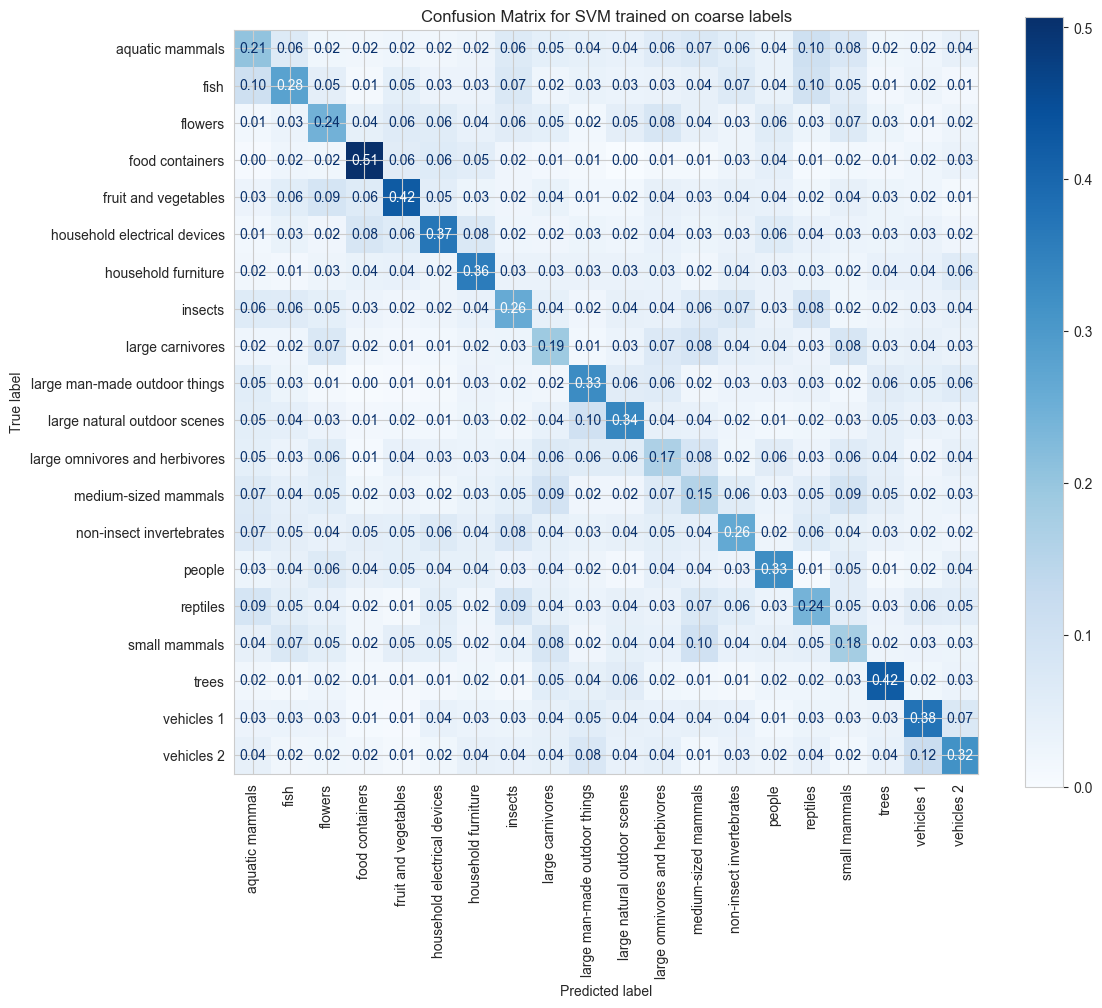

In [38]:
coarse_confusion_matrix = confusion_matrix(y_test_coarse,predictions_test_coarse, normalize='pred')
coarse_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=coarse_confusion_matrix, display_labels=coarse_list)
fig, ax = plt.subplots(figsize=(12,10))
plt.title("Confusion Matrix for SVM trained on coarse labels")
coarse_matrix_plot.plot(ax=ax, xticks_rotation='vertical', values_format= '.2f', cmap="Blues")
plt.show()

### Show classification Report for Fine labels

In [39]:
print(classification_report(y_test_fine,predictions_test_fine))

              precision    recall  f1-score   support

           0       0.52      0.53      0.52       100
           1       0.22      0.31      0.26       100
           2       0.07      0.04      0.05       100
           3       0.05      0.04      0.04       100
           4       0.04      0.03      0.04       100
           5       0.14      0.18      0.16       100
           6       0.04      0.06      0.05       100
           7       0.07      0.06      0.07       100
           8       0.37      0.41      0.39       100
           9       0.58      0.45      0.51       100
          10       0.27      0.34      0.30       100
          11       0.13      0.11      0.12       100
          12       0.15      0.15      0.15       100
          13       0.15      0.14      0.15       100
          14       0.16      0.17      0.16       100
          15       0.20      0.13      0.16       100
          16       0.42      0.30      0.35       100
          17       0.21    

### Show Confusion Matrix for Fine labels

52


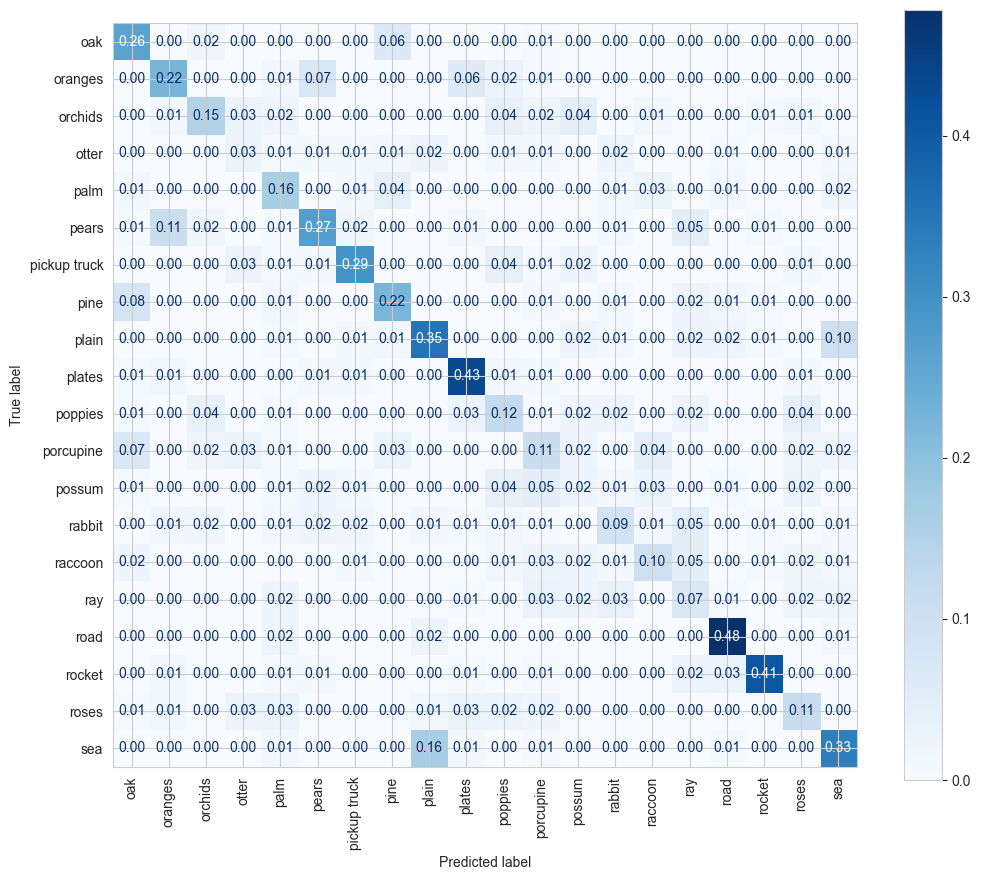

In [40]:
fine_confusion_matrix = confusion_matrix(y_test_fine,predictions_test_fine, normalize='pred')
rand_i = np.random.randint(0, 79)
print(rand_i)


first_20_matrix = fine_confusion_matrix[rand_i: rand_i+20, rand_i: rand_i+20]

fine_matrix_plot = ConfusionMatrixDisplay(confusion_matrix=first_20_matrix, display_labels=fine_list[rand_i:rand_i+20])
fig, ax = plt.subplots(figsize=(12,10))
fine_matrix_plot.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap="Blues")
plt.show()